# Student-t noise inference example

The Student-t distribution has fatter tails than the normal, meaning that it can be a better approximation to the noise process in some time series models; when there is a high degree of uncertainty regarding the underlying process, leading to a large standard deviation in a model's errors. This case study explains to the user the differences between the Student-t and the more popular normal distribution and shows how to estimate a model with Student-t errors in Pints.

Plot Student-t probability density function versus a normal.

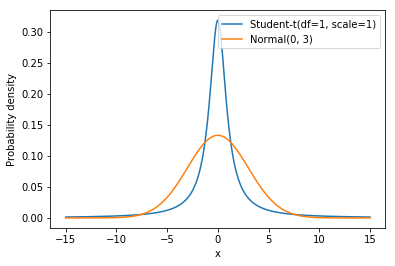

In [2]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

x = np.linspace(-15, 15, 1000)
y_t = scipy.stats.t.pdf(x, 1, loc=0, scale=1)
y_norm = scipy.stats.norm.pdf(x, 0, 3)
plt.plot(x, y_t, label ='Student-t(df=1, scale=1)')
plt.plot(x, y_norm, label ='Gaussian(0, 3)')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()
plt.show()

Compare a Student-t error process with a normal error process for the logistic model.

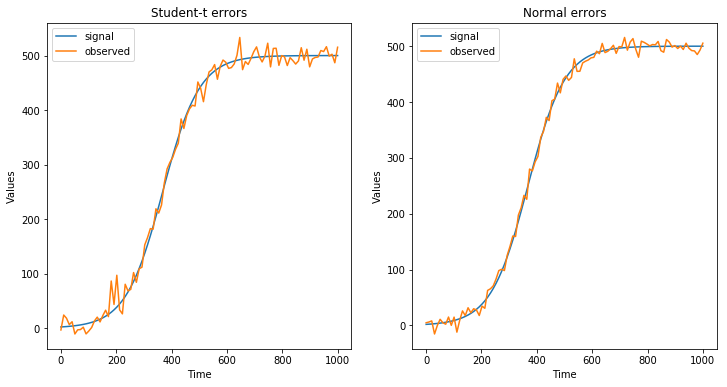

In [3]:
# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add Student-t noise
nu = 2
sigma = 10
observed_values_t = signal_values + scipy.stats.t.rvs(df=nu, loc=0, scale=sigma, size=signal_values.shape)
observed_values_norm = signal_values + scipy.stats.norm.rvs(loc=0, scale=sigma, size=signal_values.shape)
real_parameters = np.array(real_parameters + [nu, sigma])

# Plot
fig = plt.figure(figsize=(12, 6)) 
plt.subplot(121)
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values_t,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Student-t errors')
plt.legend()

plt.subplot(122)
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values_norm,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Gaussian errors')
plt.legend()
plt.show()

Specify a model using a Student-t error process and use adaptive covariance to fit it to data.

Running...
Done!
R-hat:
[1.0196851572824563, 1.0008083225625275, 1.0400053120473352, 1.0522267766990414]


/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/usr/lib64/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


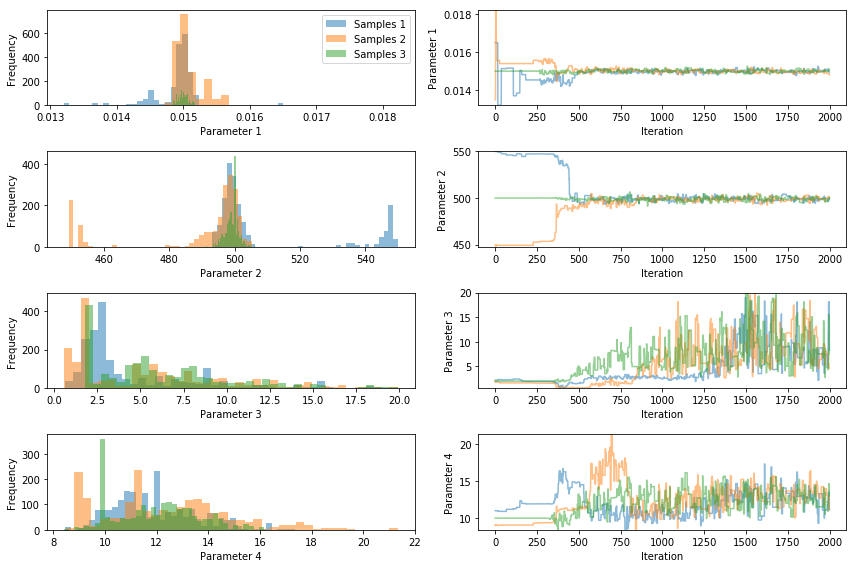

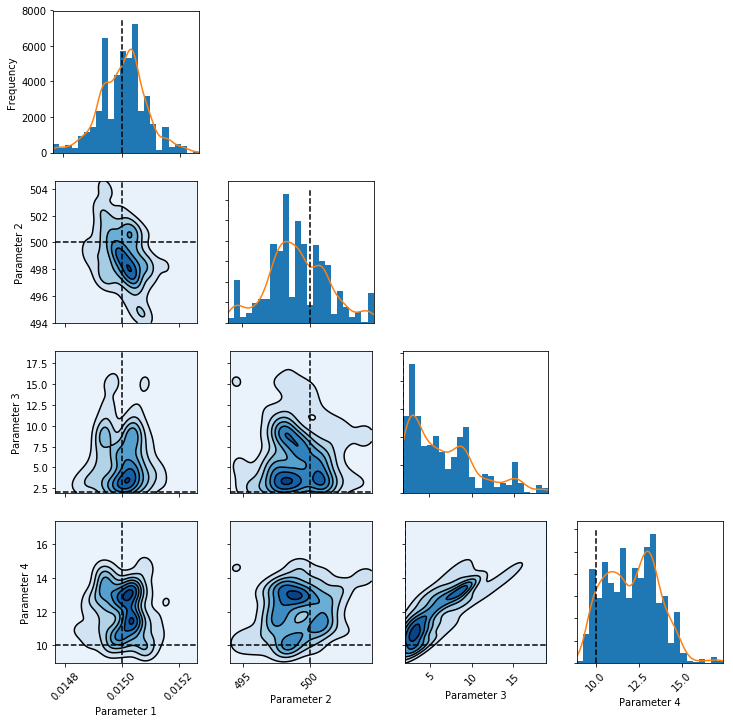

In [4]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values_t)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.StudentTLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, 0, sigma*0.1],
    [0.02, 600, nu*10, sigma*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.0,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(250)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 1000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True, ref_parameters=real_parameters)

# Show graphs
plt.show()